## Feature extraction

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

import afdetection.utils.paths as path
from afdetection.data.make_dataset import MakeDataset
from afdetection.data.signal_preprocessing import SignalPreprocessing
from afdetection.features.build_features import BuildFeatures

sns.set_theme()

## Load ECGs

In [9]:
# Leads names
leads = [
    'I',
    'II', 
    'III', 
    'aVF', 
    'aVR', 
    'aVL', 
    'V1', 
    'V2', 
    'V3', 
    'V4', 
    'V5', 
    'V6', 
]

fs = 500 # Sampling frequency

# Intantiate objects
make_data = MakeDataset()

# Load ECGs
ecg_data_DIR = path.data_raw_dir('ecgeq-500hzsrfava.npy')
ecg = make_data.read_from_np(ecg_data_DIR)

## Preprocessing

In [10]:
preprocessing = SignalPreprocessing()

### Wander removal

In [11]:
ecg_wr = preprocessing.wander_removal(ecg, fs)

# Remove first and last second of the ECGs
ecg_wr_crop = ecg_wr[:, 1*fs:-1*fs, :]
m, n, lead = ecg_wr_crop.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

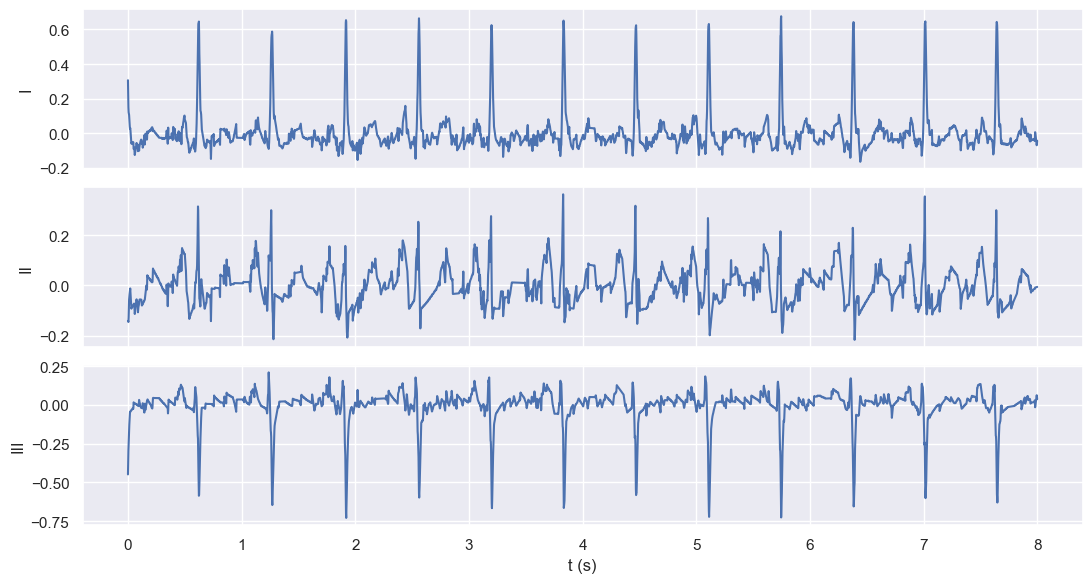

In [12]:
idx = np.random.randint(0, m)
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_wr_crop[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

### Pan–Tompkins algorithm preprocessing

In [13]:
w = int((150/1000)*fs)  # Moving average window size (150ms)
ecg_qrs = preprocessing.pan_tompkins(ecg_wr, fs, w)

# Remove first and last second of the ECGs
ecg_qrs_crop = ecg_qrs[:, 1*fs:-1*fs, :]
m, n, lead = ecg_qrs_crop.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

# Mean removal
# ecg_mr = preprocessing.mean_removal(ecg_qrs_crop)

# Normalize
# ecg_n = preprocessing.normalize(ecg_mr)

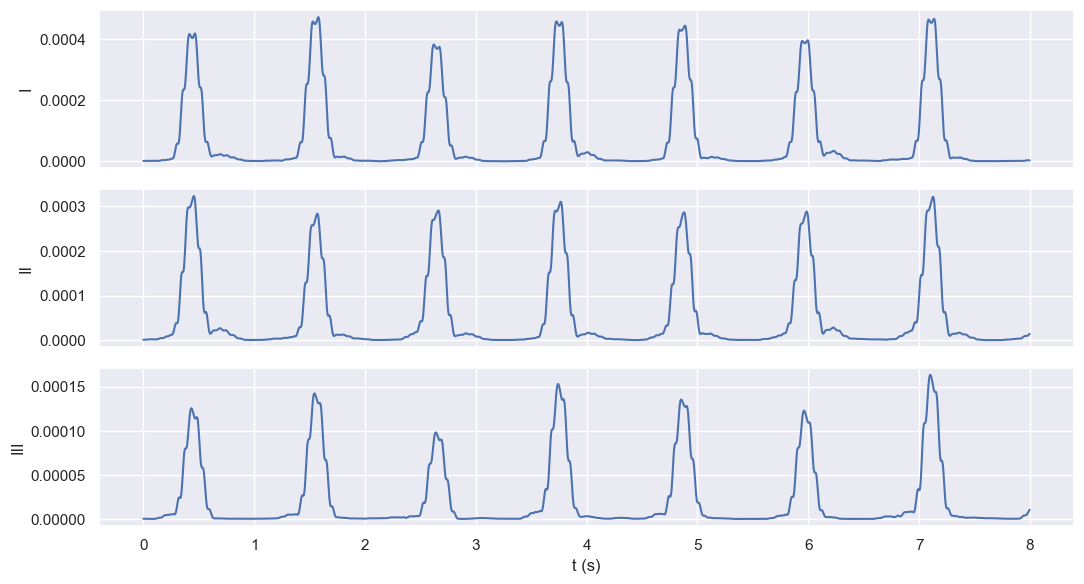

In [14]:
idx = np.random.randint(0, m)
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_qrs_crop[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Visualize frequency content

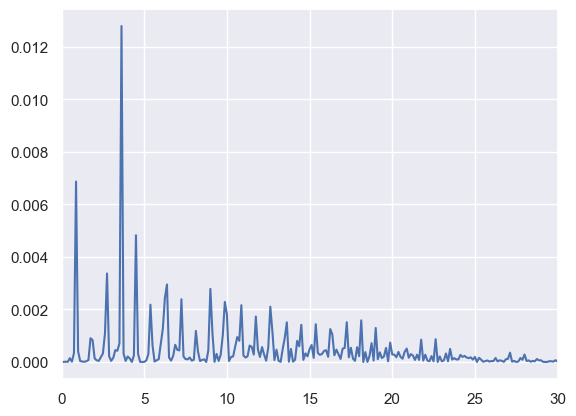

In [15]:
x = ecg_wr_crop[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x, fs)

plt.plot(freqs, Pxx)
plt.xlim([0, 30])
plt.show()

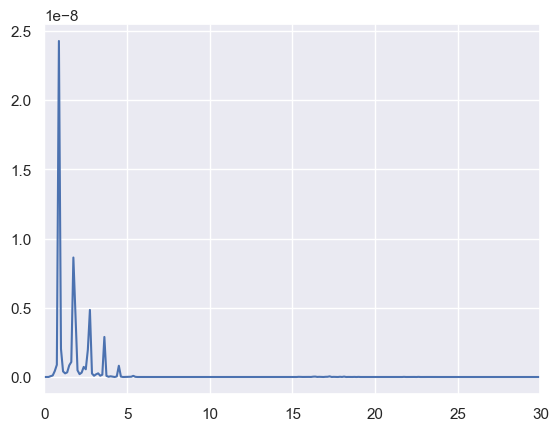

In [16]:
x = ecg_qrs_crop[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x, fs)

plt.plot(freqs, Pxx)
plt.xlim([0, 30])
plt.show()

## Build features

In [18]:
build_features = BuildFeatures()

### Spectral Entropy

In [31]:
# spectral_entropy = build_features.spectral_entropy_ecg(ecg_wr_crop, fs)
spectral_entropy = build_features.spectral_entropy_ecg(ecg_qrs_crop, fs)

In [32]:
ecg_specEn = pd.DataFrame(spectral_entropy, columns=leads)
ecg_specEn = ecg_specEn.add_suffix('_specEn')
display(ecg_specEn)

,I_specEn,II_specEn,III_specEn,aVF_specEn,aVR_specEn,aVL_specEn,V1_specEn,V2_specEn,V3_specEn,V4_specEn,V5_specEn,V6_specEn
0,1.676562,1.749363,2.268625,1.619254,1.800733,3.689650,2.767865,1.648685,1.697787,1.722314,1.673624,1.665973
1,1.676562,1.749363,2.268625,1.619254,1.800733,3.689650,2.767865,1.648685,1.697787,1.722314,1.673624,1.665973
2,2.506706,3.009748,4.409531,2.716170,2.436821,3.529405,2.677661,2.485850,2.547367,2.560969,2.608803,2.620466
3,1.148147,1.770946,2.465908,1.310650,1.089540,3.134664,0.855291,0.934886,1.486309,1.628305,1.023943,0.960868
4,3.612966,3.438919,3.890226,3.533026,3.717453,3.454853,3.560670,3.558945,3.536269,3.542047,3.571731,3.563359
...,...,...,...,...,...,...,...,...,...,...,...,...
6423,4.274991,4.221741,4.123835,4.312194,4.180064,4.145448,4.166901,4.100227,4.067787,4.075380,4.086429,4.111189
6424,3.773754,3.962813,3.920919,3.804665,3.799965,4.011297,3.935180,4.519224,4.243808,4.351523,3.767230,3.888101
6425,3.286940,3.899100,3.107284,3.880709,3.043798,3.279540,2.877888,2.852879,3.145880,2.951448,3.086531,3.104690
6426,4.338848,4.284936,4.225550,4.180253,4.124905,4.287628,4.201825,4.117103,4.095786,4.115953,4.148973,4.224494


In [33]:
data_DIR = path.data_raw_dir('ecg_features_spectral_entropy.csv')
ecg_specEn.to_csv(data_DIR, index=False)

### Dominant frequency

In [15]:
# dominant_frequency = build_features.dominant_frequency_ecg(ecg_wr_crop, fs)
dominant_frequency = build_features.dominant_frequency_ecg(ecg_qrs_crop, fs)

In [16]:
ecg_dFreq = pd.DataFrame(dominant_frequency, columns=leads)
ecg_dFreq = ecg_dFreq.add_suffix('_dFreq')
display(ecg_dFreq)

,I_dFreq,II_dFreq,III_dFreq,aVF_dFreq,aVR_dFreq,aVL_dFreq,V1_dFreq,V2_dFreq,V3_dFreq,V4_dFreq,V5_dFreq,V6_dFreq
0,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
1,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
2,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500
3,2.125,2.125,2.125,2.125,2.125,4.250,2.125,2.125,2.125,2.125,2.125,2.125
4,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750
...,...,...,...,...,...,...,...,...,...,...,...,...
6423,1.000,1.000,1.125,1.000,1.000,1.000,1.125,1.125,1.125,1.125,1.125,1.125
6424,1.750,1.750,1.750,1.750,1.750,1.750,1.750,0.875,1.750,1.750,1.750,1.750
6425,2.625,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375
6426,1.625,0.625,1.000,1.000,1.625,0.625,1.000,1.625,1.625,1.625,1.625,1.625


In [17]:
data_DIR = path.data_raw_dir('ecg_features_dominant_frequency.csv')
ecg_dFreq.to_csv(data_DIR, index=False)

### Wavelet features

In [38]:
([f'cA{level}'] + [f'cD{i}' for i in range(level, 0, -1)])

['cA5', 'cD5', 'cD4', 'cD3', 'cD2', 'cD1']

In [48]:
level = 5
w_statistics = ['energy', 'mean', 'varance', 'std_dev']
w_coeff = ([f'cA{level}'] + [f'cD{i}' for i in range(level, 0, -1)])

# [f"{x}_{y}" for x, y in list(zip(w_coeff, w_statistics))] 

[f"{x}_{y}" for y in w_statistics for x in w_coeff]

['cA5_energy',
 'cD5_energy',
 'cD4_energy',
 'cD3_energy',
 'cD2_energy',
 'cD1_energy',
 'cA5_mean',
 'cD5_mean',
 'cD4_mean',
 'cD3_mean',
 'cD2_mean',
 'cD1_mean',
 'cA5_varance',
 'cD5_varance',
 'cD4_varance',
 'cD3_varance',
 'cD2_varance',
 'cD1_varance',
 'cA5_std_dev',
 'cD5_std_dev',
 'cD4_std_dev',
 'cD3_std_dev',
 'cD2_std_dev',
 'cD1_std_dev']

In [47]:
wavelet_features[0, 0, :]

array([ 5.5013140e+01,  9.6480630e+01,  1.2150413e+02,  1.3488700e+01,
        5.9116000e-01,  1.1137000e-01,  7.5400000e-03,  1.9540000e-02,
       -2.0090000e-02,  3.2000000e-04,  0.0000000e+00, -2.1000000e-04,
        4.1989000e-01,  7.3611000e-01,  4.7422000e-01,  2.6660000e-02,
        5.9000000e-04,  6.0000000e-05,  6.4799000e-01,  8.5797000e-01,
        6.8864000e-01,  1.6327000e-01,  2.4250000e-02,  7.4500000e-03])

In [20]:
wavelet = 'db4'
level = 5

wavelet_features = build_features.wave_dec_coeffs_ecg(ecg_wr_crop, wavelet=wavelet, level=level)

print(wavelet_features.shape)

_, _, n_wf = wavelet_features.shape

ecg_waveFeat = pd.DataFrame()
for wf in range(n_wf):
    ecg_wf = pd.DataFrame(wavelet_features[:, :, wf], columns=leads)
    ecg_wf = ecg_wf.add_suffix('_wf' + str(wf+1))
    ecg_waveFeat = pd.concat([ecg_waveFeat, ecg_wf], axis=1)

display(ecg_waveFeat)

(6428, 12, 24)


,I_wf1,II_wf1,III_wf1,aVF_wf1,aVR_wf1,aVL_wf1,V1_wf1,V2_wf1,V3_wf1,V4_wf1,...,III_wf24,aVF_wf24,aVR_wf24,aVL_wf24,V1_wf24,V2_wf24,V3_wf24,V4_wf24,V5_wf24,V6_wf24
0,55.013139,71.264119,42.918361,52.474376,31.120585,43.179142,43.601033,253.349865,234.588537,216.485061,...,0.006626,0.007008,0.005807,0.006352,0.004689,0.007043,0.006197,0.005095,0.004600,0.003989
1,55.013139,71.264119,42.918361,52.474376,31.120585,43.179142,43.601033,253.349865,234.588537,216.485061,...,0.006626,0.007008,0.005807,0.006352,0.004689,0.007043,0.006197,0.005095,0.004600,0.003989
2,41.573709,64.706729,7.679530,51.302505,8.431653,25.722047,62.793633,69.978480,62.457116,202.437754,...,0.005529,0.003226,0.004354,0.004571,0.003444,0.005604,0.007402,0.008535,0.005924,0.003106
3,61.783369,125.203625,44.198301,82.570552,21.673001,69.056110,47.271544,120.710278,173.689271,206.844076,...,0.010950,0.010721,0.011822,0.007250,0.006236,0.008260,0.011303,0.011032,0.007076,0.006259
4,23.353338,27.187075,6.479728,23.663424,8.084423,10.932957,16.252078,52.226106,120.554936,113.410897,...,0.003195,0.004004,0.003545,0.002659,0.002343,0.002856,0.002924,0.003133,0.002646,0.002160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6423,8.502504,5.249891,4.811803,5.652014,5.329211,2.881981,4.440867,25.144449,29.419335,26.331666,...,0.002881,0.002817,0.002819,0.002342,0.001737,0.004325,0.003091,0.003014,0.002366,0.002055
6424,51.284600,22.345915,56.775825,22.604138,48.445592,26.641958,117.100673,952.291764,2024.974363,476.699727,...,0.005444,0.003573,0.005378,0.003292,0.003149,0.005869,0.007865,0.008152,0.008681,0.005279
6425,11.661859,14.915296,9.803721,10.853324,7.001324,9.393133,44.785543,79.501985,23.930566,29.713710,...,0.018275,0.011992,0.018358,0.010509,0.006472,0.007002,0.006147,0.006649,0.006232,0.005233
6426,15.923179,103.550777,79.284156,39.955982,21.737724,87.357097,15.277167,135.544469,189.597650,172.081497,...,0.004671,0.006780,0.005271,0.004444,0.002681,0.003718,0.003936,0.003332,0.003204,0.002823


In [19]:
data_DIR = path.data_raw_dir('ecg_features_wavelet.csv')
ecg_waveFeat.to_csv(data_DIR, index=False)